In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
STATE = 'California'
COUNTY = 'Orange'

DATA_DIR = 'nyt-data'

def calculate_daily_stats(df):
    df = df.set_index('date')
    df['cases'] = df['cases'].diff().fillna(df['cases'])
    df['deaths'] = df['deaths'].diff().fillna(df['deaths'])
    return df

country_df = pd.concat(
    [
        pd.read_csv(os.path.join(DATA_DIR, 'us.csv')),
        pd.read_csv(os.path.join(DATA_DIR, 'live', 'us.csv')),
    ],
    join='inner',
)
country_df = calculate_daily_stats(country_df)
state_df = pd.concat(
    [
        pd.read_csv(os.path.join(DATA_DIR, 'us-states.csv')),
        pd.read_csv(os.path.join(DATA_DIR, 'live', 'us-states.csv')),
    ],
    join='inner',
)
state_df = calculate_daily_stats(state_df[state_df['state'] == STATE])
county_df = pd.concat(
    [
        pd.read_csv(os.path.join(DATA_DIR, 'us-counties.csv')),
        pd.read_csv(os.path.join(DATA_DIR, 'live', 'us-counties.csv')),
    ],
    join='inner',
)
county_df = calculate_daily_stats(county_df[(county_df['state'] == STATE) & (county_df['county'] == COUNTY)])

print(country_df.tail())
print(state_df.tail())
print(county_df.tail())

              cases  deaths
date                       
2020-08-04  53395.0  1358.0
2020-08-05  53726.0  1253.0
2020-08-06  57338.0  1071.0
2020-08-07  60975.0  1354.0
2020-08-08  52899.0   944.0
                 state  fips   cases  deaths
date                                        
2020-08-04  California     6  5023.0   196.0
2020-08-05  California     6  5518.0   170.0
2020-08-06  California     6  8237.0   148.0
2020-08-07  California     6  7129.0   183.0
2020-08-08  California     6  7840.0   102.0
            county       state    fips  cases  deaths
date                                                 
2020-08-04  Orange  California  6059.0  253.0     2.0
2020-08-05  Orange  California  6059.0   65.0    12.0
2020-08-06  Orange  California  6059.0  580.0    32.0
2020-08-07  Orange  California  6059.0   43.0     7.0
2020-08-08  Orange  California  6059.0  322.0    16.0


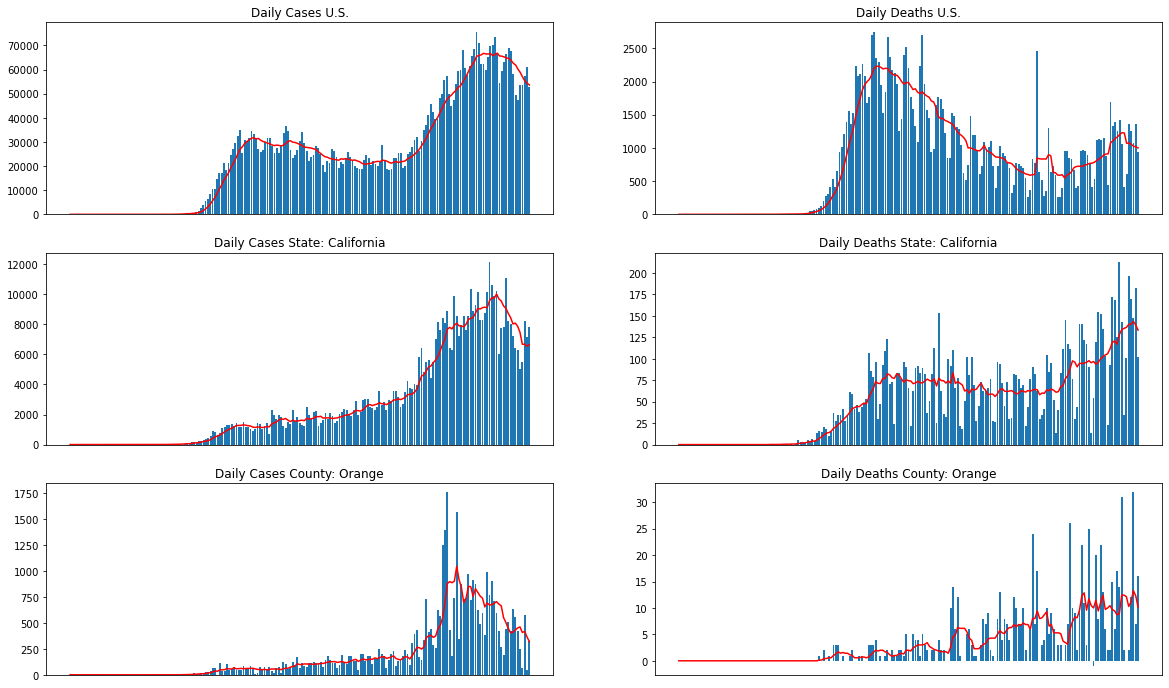

In [3]:
SIZE = (20, 12)

fig, axs = plt.subplots(3, 2, figsize=SIZE)

axs[0][0].bar(country_df.index, country_df['cases'])
axs[0][0].plot(country_df.index, country_df['cases'].rolling(7, 1).mean(), color='red')
axs[0][0].set(xticks=[], title='Daily Cases U.S.')
axs[0][1].bar(country_df.index, country_df['deaths'])
axs[0][1].plot(country_df.index, country_df['deaths'].rolling(7, 1).mean(), color='red')
axs[0][1].set(xticks=[], title='Daily Deaths U.S.')

axs[1][0].bar(state_df.index, state_df['cases'])
axs[1][0].plot(state_df.index, state_df['cases'].rolling(7, 1).mean(), color='red')
axs[1][0].set(xticks=[], title=f'Daily Cases State: {STATE}')
axs[1][1].bar(state_df.index, state_df['deaths'])
axs[1][1].plot(state_df.index, state_df['deaths'].rolling(7, 1).mean(), color='red')
axs[1][1].set(xticks=[], title=f'Daily Deaths State: {STATE}')

axs[2][0].bar(county_df.index, county_df['cases'])
axs[2][0].plot(county_df.index, county_df['cases'].rolling(7, 1).mean(), color='red')
axs[2][0].set(xticks=[], title=f'Daily Cases County: {COUNTY}')
axs[2][1].bar(county_df.index, county_df['deaths'])
axs[2][1].plot(county_df.index, county_df['deaths'].rolling(7, 1).mean(), color='red')
axs[2][1].set(xticks=[], title=f'Daily Deaths County: {COUNTY}')

plt.show()